# Телеком

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь;
2. Интернет.


### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.


Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostClassifier
from catboost import Pool

from sklearn.metrics import roc_auc_score
from catboost.utils import get_roc_curve
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

## Информация о договоре

In [2]:
try:
    data_contract = pd.read_csv('/Users/daniilsobolev/Desktop/final/final_provider/contract.csv')
except:
    data_contract = pd.read_csv('/datasets/final_provider/contract.csv')

In [3]:
data_contract.sample(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1289,9968-FFVVH,2014-11-01,No,One year,No,Bank transfer (automatic),68.80,4111.35
6531,4923-ADWXJ,2018-01-01,No,Month-to-month,Yes,Bank transfer (automatic),65.80,1679.65
6808,1116-DXXDF,2016-11-01,No,Two year,Yes,Electronic check,100.45,3801.7


Описание столбцов:

- **customerID** - персональный id пользователя,
- **BeginDate** – дата начала пользования услугами,
- **EndDate** – дата окончания пользования услугами,
- **Type** – тип оплаты: ежемесячный, годовой и тд,
- **PaperlessBilling** – электронный документ об оплате,
- **PaymentMethod** – способ оплаты,
- **MonthlyCharges** – ежемесячные траты на услуги,
- **TotalCharges** – всего потрачено денег на услуги

In [4]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
data_contract.columns = ['customer_id', 
                         'begin_date', 
                         'end_date', 
                         'type', 
                         'paperless_billing', 
                         'payment_method', 
                         'monthly_charges',
                         'total_charges',
                        ]

### Колонка begin_date

In [6]:
print(
    f'Период дат начала пользования: {data_contract["begin_date"].min()} -- {data_contract["begin_date"].max()}'
)

Период дат начала пользования: 2013-10-01 -- 2020-02-01


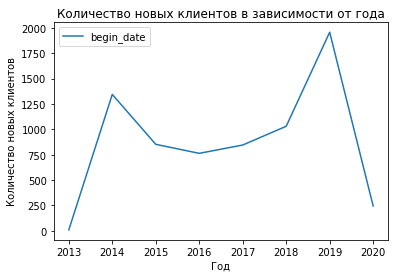

In [7]:
data_contract['begin_date'] = pd.to_datetime(data_contract['begin_date'])

data_contract_begin = data_contract[['begin_date']]
data_contract_begin['year'] = data_contract_begin['begin_date'].dt.year
data_contract_begin.groupby('year').count().plot()
plt.xlabel("Год")
plt.ylabel("Количество новых клиентов")
plt.title("Количество новых клиентов в зависимости от года")
plt.show()

### Колонка end_date

In [8]:
data_contract['end_date'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: end_date, dtype: int64

Чтобы перевести весь столбец в формат дата-время, заменим значение 'No' на значение '2100-01-01', в будущем понимаю, что это 'No'

In [9]:
data_contract.loc[(data_contract.end_date == 'No'), 'end_date'] = '2100-01-01'

### Колонка type

In [10]:
data_contract['type'].value_counts(normalize=True)

Month-to-month    0.550192
Two year          0.240664
One year          0.209144
Name: type, dtype: float64

### Колонка paperless_billing

In [11]:
data_contract['paperless_billing'].value_counts(normalize=True)

Yes    0.592219
No     0.407781
Name: paperless_billing, dtype: float64

### Колонка payment_method

In [12]:
data_contract['payment_method'].value_counts(normalize=True)

Electronic check             0.335794
Mailed check                 0.228880
Bank transfer (automatic)    0.219225
Credit card (automatic)      0.216101
Name: payment_method, dtype: float64

### Колонка monthly_charges

In [13]:
print(
    f'Мин-Макс ежемесячного платежа: {data_contract["monthly_charges"].min()}' 
    + f' -- {data_contract["monthly_charges"].max()}'
)

Мин-Макс ежемесячного платежа: 18.25 -- 118.75


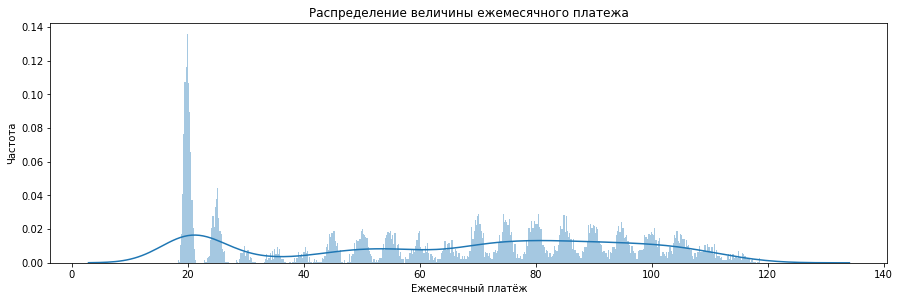

In [14]:
plt.figure(figsize=(15,15))
plt.subplot(312)
sns.distplot(data_contract['monthly_charges'], bins=500)

plt.xlabel("Ежемесячный платёж")
plt.ylabel("Частота")
plt.title("Распределение величины ежемесячного платежа")
plt.show()

### Колонка total_charges

Недавно подключившиеся клиенты (2020-02-01), ещё не успели внести оплату: 

In [15]:
data_contract.loc[(data_contract.begin_date == '2020-02-01')]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,2100-01-01,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,2100-01-01,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,2100-01-01,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,2100-01-01,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,2100-01-01,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,2100-01-01,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,2100-01-01,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,2100-01-01,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,2100-01-01,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,2100-01-01,Two year,No,Mailed check,73.35,


Поэтому в колонке total_charges пропуски заменим на нули

In [16]:
data_contract.loc[(data_contract.begin_date == '2020-02-01'), 'total_charges'] = '0'

In [17]:
print(
    f'Мин-Макс суммарного платежа: {data_contract["total_charges"].min()}' 
    + f' -- {data_contract["total_charges"].max()}'
)

Мин-Макс суммарного платежа: 0 -- 999.9


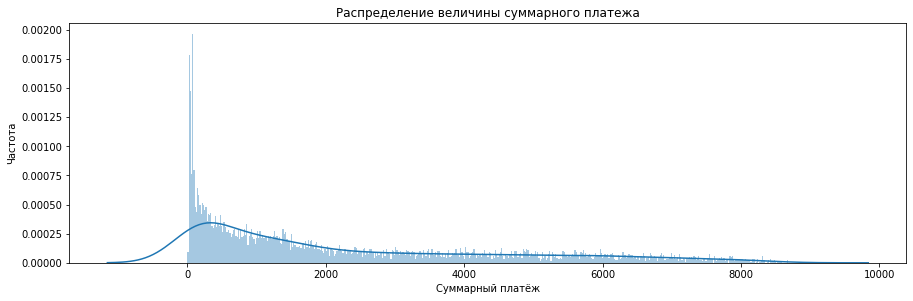

In [18]:
plt.figure(figsize=(15,15))
plt.subplot(312)
sns.distplot(data_contract['total_charges'], bins=500)

plt.xlabel("Суммарный платёж")
plt.ylabel("Частота")
plt.title("Распределение величины суммарного платежа")
plt.show()

### Вывод

In [19]:
data_contract.head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,2100-01-01,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,2100-01-01,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15


In [20]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


Был проведен небольшой просмотр таблицы data_contract. Всего в ней 7043 элемента, 8 признаков. <br>
Некоторые данные приведены к более интуитывным типам.

Период дат начала пользования: 2013-10-01 -- 2020-02-01

Даты окончания пользования: 2019-11-01, 2019-12-01, 2020-01-01, 2019-10-01, либо без окончания(продолжают пользоваться). Что может говорить либо об ошибке в данных, либо о том, что маркетинговый отдел придумал, как удерживать клиентов на долго, но возможна и другая причина.

Всего существует три тарифа: оплата от месяца к месяцу, ежегодно, раз в два года. Оплата раз в год и в два года как раз и могла послужить тому, что клиенты не расстаются с сервисом.

Также нам доступна информация о способе платежа. И выдавлся ли бумажный чек. Но, думаю, эта информация не столь информативна.

Замечено, что ежемесячный платеж - это волнообразный график, что может говорить о том, что нет четко фиксированного тарифа, но в то же время есть определенные стандартные цены на тарифы. Самый частый ежемесячный платеж -- 20.

Распределение суммарного платежа -  всё время убывающая зависимость. Что естественно, ведь число людей с большими ежемесячными платежами или число людей пользующихся сервисом долгое время меньше.

## Информация о клиенте

In [21]:
try:
    data_personal = pd.read_csv('/Users/daniilsobolev/Desktop/final/final_provider/personal.csv')
except:
    data_personal = pd.read_csv('/datasets/final_provider/personal.csv')

In [22]:
data_personal.sample(3)

,customerID,gender,SeniorCitizen,Partner,Dependents
1337,6265-FRMTQ,Male,0,No,No
7016,1471-GIQKQ,Female,0,No,No
6788,1760-CAZHT,Male,0,No,Yes


Описание столбцов:

- **customerID** - персональный id пользователя,
- **gender** – пол,
- **SeniorCitizen** – наличие пенсионного статуса по возрасту,
- **Partner** – наличие супруга(и),
- **Dependents** –  наличие иждивенцев

In [23]:
data_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [24]:
data_personal.columns = ['customer_id', 
                         'gender', 
                         'senior_citizen', 
                         'partner', 
                         'dependents',
                        ]

### Колонка gender

In [25]:
data_personal['gender'].value_counts(normalize=True)

Male      0.504756
Female    0.495244
Name: gender, dtype: float64

### Колонка senior_citizen

In [26]:
data_personal['senior_citizen'].value_counts(normalize=True)

0    0.837853
1    0.162147
Name: senior_citizen, dtype: float64

### Колонка partner

In [27]:
data_personal['partner'].value_counts(normalize=True)

No     0.516967
Yes    0.483033
Name: partner, dtype: float64

### Колонка dependents

In [28]:
data_personal['dependents'].value_counts(normalize=True)

No     0.700412
Yes    0.299588
Name: dependents, dtype: float64

### Вывод

In [29]:
data_personal.sample(3)

,customer_id,gender,senior_citizen,partner,dependents
4976,8165-CBKXO,Male,0,Yes,Yes
6728,2380-DAMQP,Female,0,Yes,No
3196,4393-OBCRR,Female,0,No,No


In [30]:
data_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


В данной таблице также 7043 элемента.

В признаках содержится информация о клиентах: пол, является ли пенсионером, есть ли супруг(а), наличие еждевенцем.

## Информация об интерент-услугах

In [31]:
try:
    data_internet = pd.read_csv('/Users/daniilsobolev/Desktop/final/final_provider/internet.csv')
except:
    data_internet = pd.read_csv('/datasets/final_provider/internet.csv')

In [32]:
data_internet.sample(3)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3286,4395-PZMSN,Fiber optic,No,Yes,No,No,No,Yes
5433,2898-MRKPI,Fiber optic,No,Yes,No,No,Yes,Yes
3194,0916-QOFDP,Fiber optic,No,No,No,No,Yes,Yes


Описание столбцов:

- **customerID** - персональный id пользователя,
- **InternetService** – тип подключения,
- **OnlineSecurity** – наличие блокировки небезопасных сайтов,
- **OnlineBackup** – наличие облачного хранилища файлов для резервного копирования данных,
- **DeviceProtection** –  наличие антивируса,
- **TechSupport** - наличие выделенной линии технической поддержки,
- **StreamingTV** – наличие стримингового телевидения,
- **StreamingMovies** – наличие каталога фильмов

In [33]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [34]:
data_internet.columns = ['customer_id', 
                         'internet_service', 
                         'online_security', 
                         'online_backup', 
                         'device_protection',
                         'tech_support',
                         'streaming_tv',
                         'streaming_movies',
                        ]

### Колонка internet_service

In [35]:
data_internet['internet_service'].value_counts(normalize=True)

Fiber optic    0.561175
DSL            0.438825
Name: internet_service, dtype: float64

### Колонка online_security

In [36]:
data_internet['online_security'].value_counts(normalize=True)

No     0.63404
Yes    0.36596
Name: online_security, dtype: float64

### Колонка online_backup

In [37]:
data_internet['online_backup'].value_counts(normalize=True)

No     0.559724
Yes    0.440276
Name: online_backup, dtype: float64

### Колонка device_protection

In [38]:
data_internet['device_protection'].value_counts(normalize=True)

No     0.560993
Yes    0.439007
Name: device_protection, dtype: float64

### Колонка tech_support

In [39]:
data_internet['tech_support'].value_counts(normalize=True)

No     0.629509
Yes    0.370491
Name: tech_support, dtype: float64

### Колонка streaming_tv

In [40]:
data_internet['streaming_tv'].value_counts(normalize=True)

No     0.509335
Yes    0.490665
Name: streaming_tv, dtype: float64

### Колонка streaming_movies

In [41]:
data_internet['streaming_movies'].value_counts(normalize=True)

No     0.504803
Yes    0.495197
Name: streaming_movies, dtype: float64

### Вывод

In [42]:
data_internet.sample(3)

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
3031,2403-BCASL,Fiber optic,No,Yes,Yes,Yes,Yes,Yes
134,3445-HXXGF,DSL,No,Yes,Yes,No,No,Yes
4493,5937-EORGB,Fiber optic,Yes,No,Yes,No,Yes,No


In [43]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


В таблице 5517 строк, что меньше 7043, значит не все клиенты ползьуются услугами интернета.

В таблице 7 признаков -- дополнительные фичи при подключении: тип кабеля, антивирус, резервное копирование, блокировка небезопасных сайтов, тех поддержка, стриминговое тв, каталог фильмов.

## Информация об услугах телефонии

In [44]:
try:
    data_phone = pd.read_csv('/Users/daniilsobolev/Desktop/final/final_provider/phone.csv')
except:
    data_phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [45]:
data_phone.sample(3)

,customerID,MultipleLines
709,0285-INHLN,No
5665,4476-OSWTN,Yes
948,3354-OADJP,No


Описание столбцов:

- **customerID** - персональный id пользователя,
- **MultipleLines** – наличие возможности ведения параллельных линий во время звонка

In [46]:
data_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [47]:
data_phone.columns = ['customer_id',
                      'multiple_lines',
                     ]

### Колонка multiple_lines

In [48]:
data_phone['multiple_lines'].value_counts(normalize=True)

No     0.532935
Yes    0.467065
Name: multiple_lines, dtype: float64

### Вывод

In [49]:
data_phone.sample(3)

,customer_id,multiple_lines
3213,4311-QTTAI,No
4690,7105-BENQF,No
2064,2054-PJOCK,Yes


In [50]:
data_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


В таблице 6361 строка, что также говорит о том, что услугами телефонии пользуются не все клиенты сервиса. 

В таблице всего один признак, отвечающий за ифнормацию о том было ли наличие возможности ведения параллельных линий во время звонка.

## Предобработка данных

#### Джоин таблиц

Заджойним все таблицы в одну. Джойн будем делать по общей для всех колонке - customer_id. В датасете data_personal есть все 7043 строки, поэтому к нему будем присоеденять остальные с помощью left join.

In [51]:
data = data_contract.merge(data_personal, how='left', left_on='customer_id', right_on='customer_id')

In [52]:
data = data.merge(data_internet, how='left', left_on='customer_id', right_on='customer_id')

In [53]:
data = data.merge(data_phone, how='left', left_on='customer_id', right_on='customer_id')

#### Проверка на дубликаты

In [54]:
data.duplicated().sum()

0

#### Заполнение пропусков

Пропуски не восстанавливаемые, так как пропуски связаны с тем, что клиент не пользовался либо услугами интернета, либо услугами телефонии. Заменим их на -1, имея в виду, что это пропуск.

In [55]:
data = data.fillna(-1)

#### Приведение типов

Тип признаков **monthly_charges** и **total_charges** поменяем на float

In [56]:
data['total_charges'] = data['total_charges'].astype(float)
data['monthly_charges'] = data['monthly_charges'].astype(float)

Тип признаков **end_date** и **begin_date** изменим на datetime

In [57]:
data['end_date'] = pd.to_datetime(data['end_date'])
data['begin_date'] = pd.to_datetime(data['begin_date'])

### Информация об итоговой таблице:

In [58]:
data.sample(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
1729,8226-BXGES,2014-10-01,2100-01-01,One year,No,Bank transfer (automatic),89.45,5692.65,Male,0,Yes,No,Fiber optic,Yes,Yes,Yes,No,No,No,Yes
4960,7480-QNVZJ,2015-11-01,2020-01-01,Month-to-month,Yes,Electronic check,95.70,4816.70,Male,1,No,No,Fiber optic,No,No,No,No,Yes,Yes,Yes
3325,0697-ZMSWS,2019-07-01,2019-11-01,Month-to-month,Yes,Electronic check,85.65,338.90,Male,0,No,No,Fiber optic,No,No,No,No,No,Yes,Yes
5522,2619-WFQWU,2019-12-01,2020-01-01,Month-to-month,Yes,Mailed check,70.15,70.15,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
4833,8510-BBWMU,2016-09-01,2100-01-01,One year,Yes,Mailed check,19.75,806.95,Female,0,No,No,-1,-1,-1,-1,-1,-1,-1,No


In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

### Выделим таргет

Нам известна дата начала пользования клиентом услугами, а также дата окончания.

Нам будет необходимо предсказывать уйдет ли клиент с сервиса или нет.

Поэтому предлагаю из двух признаков **end_date** и **begin_date** сделать два других: 

- Клиент ушел или нет **0/1**
- Количество дней пользования услугами **int**

Также не забудем, что значения **No** мы пометили датой **2100-01-01**

Актуальная дата - 2020-02-01

In [60]:
data['is_gone'] = 1
data.loc[(data['end_date'] == '2100-01-01'), 'is_gone'] = 0


data.loc[(data.end_date == '2100-01-01'), 'end_date'] = '2020-02-01'
data['end_date'] = pd.to_datetime(data['end_date'])
data['day_interval'] = (data['end_date']-data['begin_date']).dt.days 

In [61]:
data = data.drop(['begin_date', 'end_date'], axis = 1)

In [62]:
data.sample(2)

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,is_gone,day_interval
6829,8148-WOCMK,Two year,No,Credit card (automatic),19.6,125.0,Male,0,Yes,Yes,-1,-1,-1,-1,-1,-1,-1,No,0,245
4595,2211-RMNHO,Two year,No,Bank transfer (automatic),85.3,5560.0,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,Yes,Yes,0,2071


<AxesSubplot:>

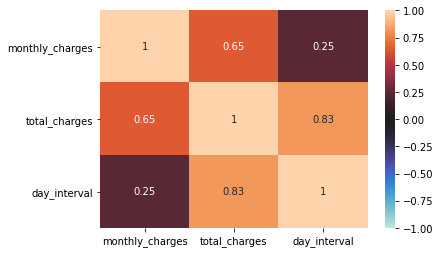

In [63]:
sns.heatmap(data[['monthly_charges', 'total_charges', 'day_interval']].corr(), annot=True, vmin=-1, vmax=1, center= 0)

Из матрицы видно, что некоторые похожие признаки сильно коррелируют.

Они могут испортить показатели метрик, поэтому нам может хватить лишь одного из них. Проверим это при обучении.

Признак customer_id не пригодится при обучении, удалим его:

In [64]:
data = data.drop(['customer_id'], axis=1)

Посмотрим на баланс классов:

In [65]:
data['is_gone'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: is_gone, dtype: float64

У нас есть дисбаланс классов. Поэтому в будущем можно добалансировать. Например, техникой upsampling увеличить меньший класс отдельно для теста, отдельно для обучения.

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   gender             7043 non-null   object 
 6   senior_citizen     7043 non-null   int64  
 7   partner            7043 non-null   object 
 8   dependents         7043 non-null   object 
 9   internet_service   7043 non-null   object 
 10  online_security    7043 non-null   object 
 11  online_backup      7043 non-null   object 
 12  device_protection  7043 non-null   object 
 13  tech_support       7043 non-null   object 
 14  streaming_tv       7043 non-null   object 
 15  streaming_movies   7043 non-null   object 
 16  multiple_lines     7043 

## Исследовательский анализ данных

Исследуем зависимость ухода от различных признаков, напишем общую функцию для построения гистограмм 

In [67]:
def plot_hist(data, column):
  plt.figure(figsize=(12,6))
  data[column].hist(alpha=0.7)
  data[data['is_gone'] == 1][column].hist(alpha=0.7)
  plt.legend(['Все пользователи', 'Количество ушедших'])
  plt.title(f'Количество ушедших по признаку {column}')
  plt.ylabel('Количество человек')
  plt.show()

### Зависимость ухода от пола

In [68]:
data.groupby('gender')['is_gone'].agg(['mean'])

,mean
gender,
Female,0.269209
Male,0.261603


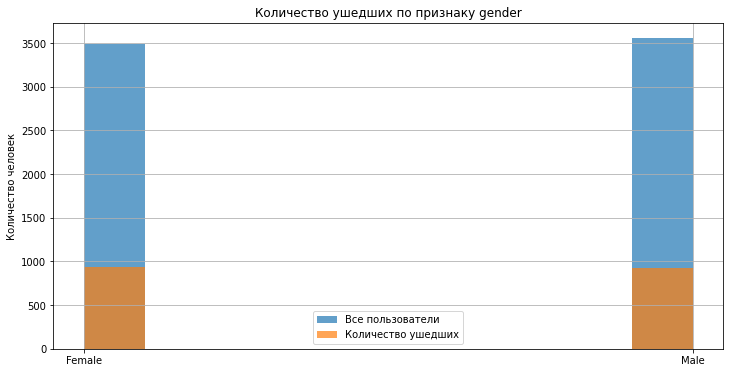

In [69]:
plot_hist(data, 'gender')

Можем сделать вывод, что пол скорее всего не влияет на уход.

### Зависимость ухода от типа оплаты

In [70]:
data.groupby('type')['is_gone'].agg(['mean'])

,mean
type,
Month-to-month,0.427097
One year,0.112695
Two year,0.028319


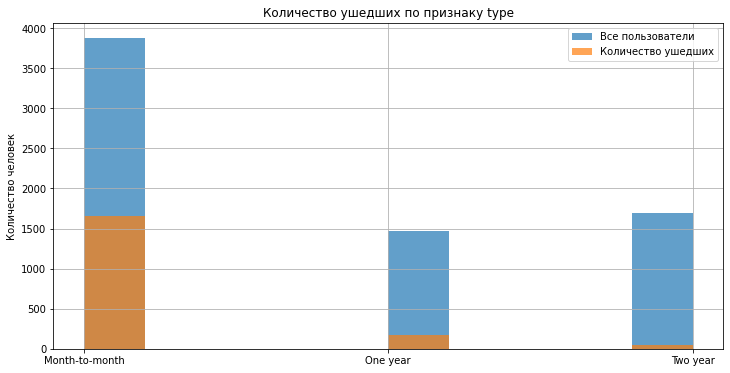

In [71]:
plot_hist(data, 'type')

Из графиков видно, что чем на большее время у человека была подписка, тем на дольшее время он оставался, что должно быть логично

### Зависимость ухода от метода оплаты

In [72]:
data.groupby('payment_method')['is_gone'].agg(['mean'])

,mean
payment_method,
Bank transfer (automatic),0.167098
Credit card (automatic),0.152431
Electronic check,0.452854
Mailed check,0.191067


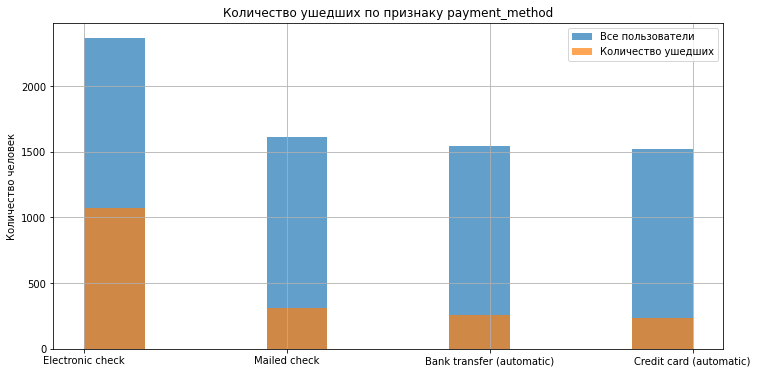

In [73]:
plot_hist(data, 'payment_method')

Интересный факт, но люди с электронным чеком уходили чаще, возможно, это может быть связано с тем, что люди получавшие электронные чеки, могли подключать услуги и отключать в онлайне, а отказаться от услуг нажав на кнопку много проще, чем сказать нет менеджеру при встрече.

### Зависимость ухода от признака paperless_billing

In [74]:
data.groupby('paperless_billing')['is_gone'].agg(['mean'])

,mean
paperless_billing,
No,0.163301
Yes,0.335651


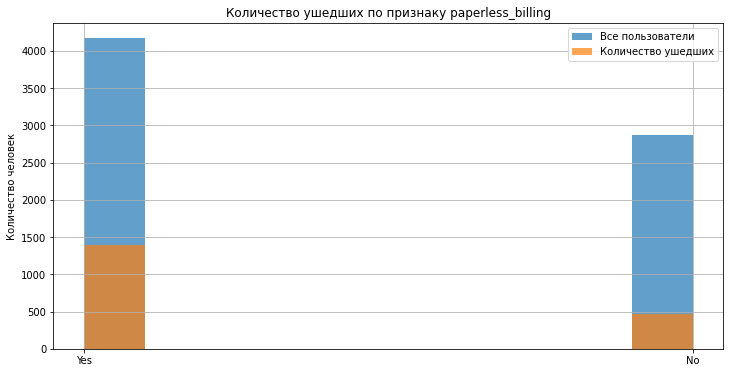

In [75]:
plot_hist(data, 'paperless_billing')

Люди без бумажных чеков уходят чаще.

### Зависимость ухода от наличия партенра

In [76]:
data.groupby('partner')['is_gone'].agg(['mean'])

,mean
partner,
No,0.329580
Yes,0.196649


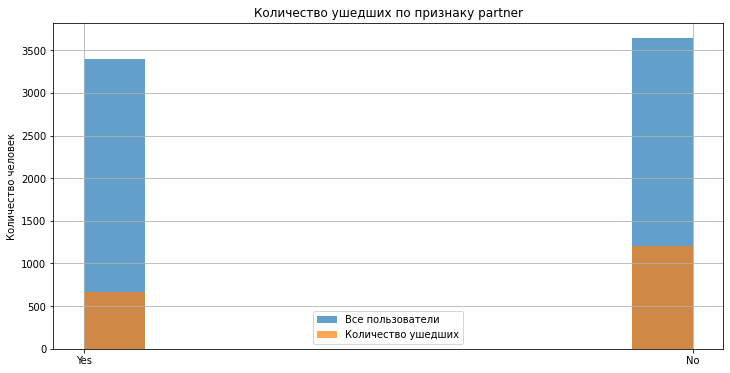

In [77]:
plot_hist(data, 'partner')

Клиенты без партнера уходят немного чаще, чем клиенты с партнером.

### Зависимость ухода от наличия еждевенцев

In [78]:
data.groupby('dependents')['is_gone'].agg(['mean'])

,mean
dependents,
No,0.312791
Yes,0.154502


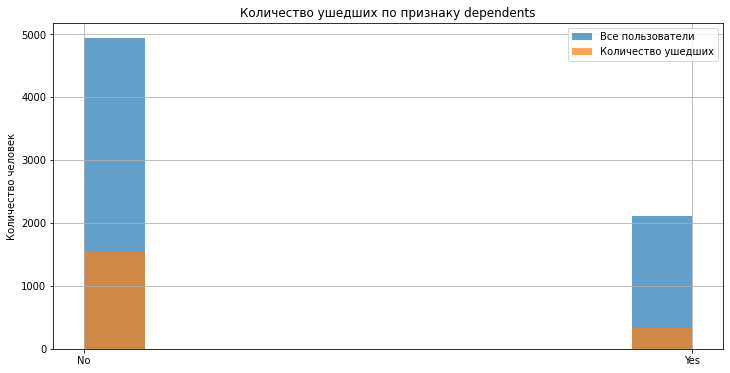

In [79]:
plot_hist(data, 'dependents')

При наличие еждевенца, клиенты уходят реже.

### Зависимость ухода при достижении пенсионного возраста и нет

In [80]:
data.groupby('senior_citizen')['is_gone'].agg(['mean'])

,mean
senior_citizen,
0,0.236062
1,0.416813


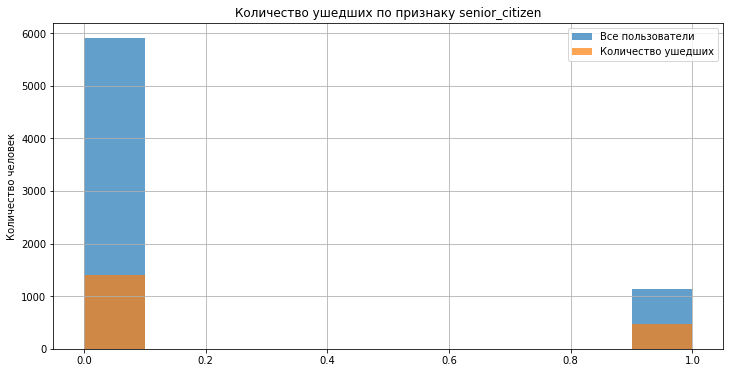

In [81]:
plot_hist(data, 'senior_citizen')

Пенсионеры уходят чаще. Даже несмотря на та то, что большая вероятность того, что пенсионеры пользуются бумажными чеками и не электронным типом оплаты.

### Зависмость от услуги internet_service

In [82]:
data.groupby('internet_service')['is_gone'].agg(['mean'])

,mean
internet_service,
-1,0.074050
DSL,0.189591
Fiber optic,0.418928


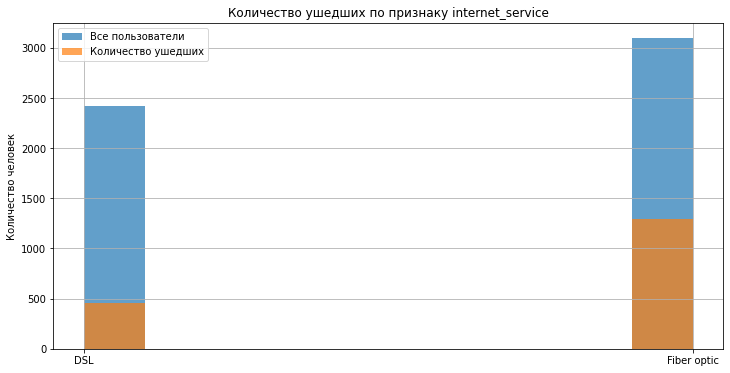

In [83]:
plot_hist(data.loc[(data['internet_service'] != -1)], 'internet_service')

Возможно, тип соединения Fiber optic хуже как продукт и клиенты разочаровываются в нем. Надо допросить инженеров.

### Зависимость от улсуги online_security

In [84]:
data.groupby('online_security')['is_gone'].agg(['mean'])

,mean
online_security,
-1,0.074050
No,0.417667
Yes,0.146112


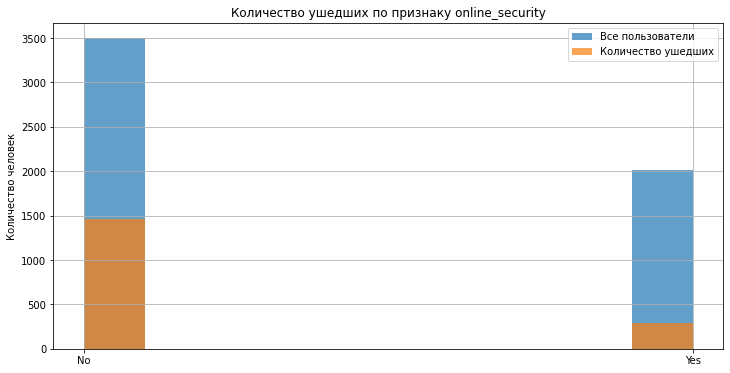

In [85]:
plot_hist(data.loc[(data['online_security'] != -1)], 'online_security')

Те, кто подключил услугу online_security, уходят реже

### Зависимость улсуги от online_backup

In [86]:
data.groupby('online_backup')['is_gone'].agg(['mean'])

,mean
online_backup,
-1,0.074050
No,0.399288
Yes,0.215315


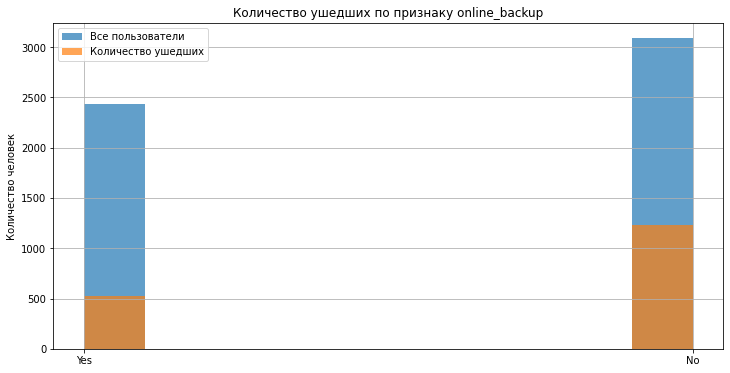

In [87]:
plot_hist(data.loc[(data['online_backup'] != -1)], 'online_backup')

Аналогично прошлому призанку.

### Зависимость услуги от device_protection

In [88]:
data.groupby('device_protection')['is_gone'].agg(['mean'])

,mean
device_protection,
-1,0.074050
No,0.391276
Yes,0.225021


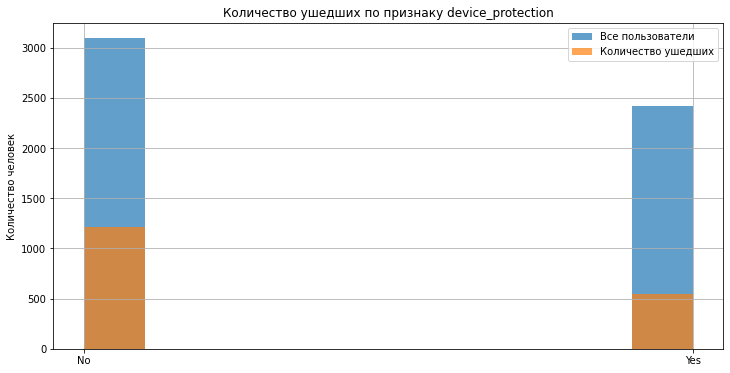

In [89]:
plot_hist(data.loc[(data['device_protection'] != -1)], 'device_protection')

Аналогично прошлому признаку, возможно, люди, кто подключал себе дополнительные услуги, уходят реже.

### Зависимость улсуги от tech_support

In [90]:
data.groupby('tech_support')['is_gone'].agg(['mean'])

,mean
tech_support,
-1,0.074050
No,0.416355
Yes,0.151663


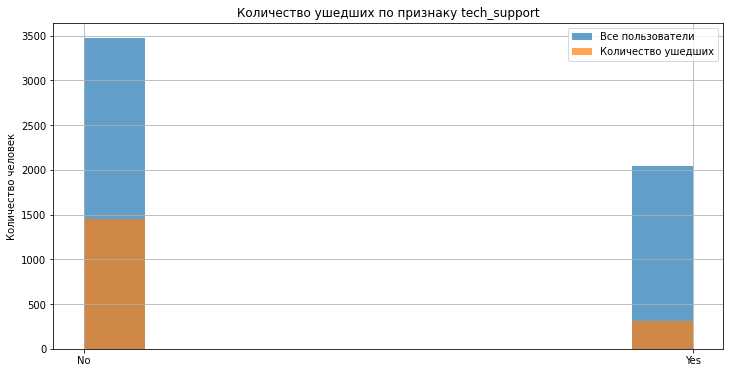

In [91]:
plot_hist(data.loc[(data['tech_support'] != -1)], 'tech_support')

Аналогично

### Зависимость услуги от streaming_tv

In [92]:
data.groupby('streaming_tv')['is_gone'].agg(['mean'])

,mean
streaming_tv,
-1,0.074050
No,0.335231
Yes,0.300702


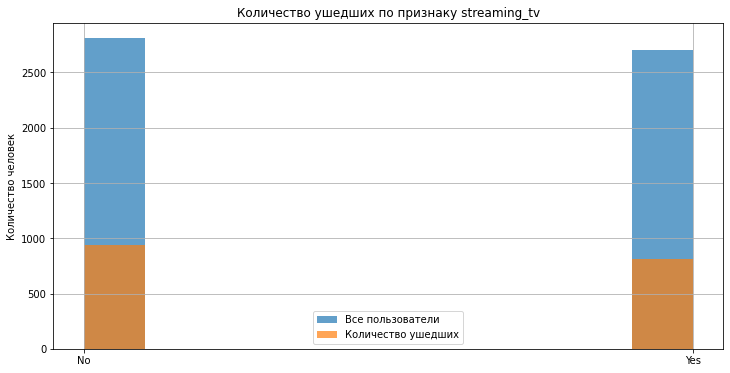

In [93]:
plot_hist(data.loc[(data['streaming_tv'] != -1)], 'streaming_tv')

### Зависимость улсуги от streaming_movies

In [94]:
data.groupby('streaming_movies')['is_gone'].agg(['mean'])

,mean
streaming_movies,
-1,0.074050
No,0.336804
Yes,0.299414


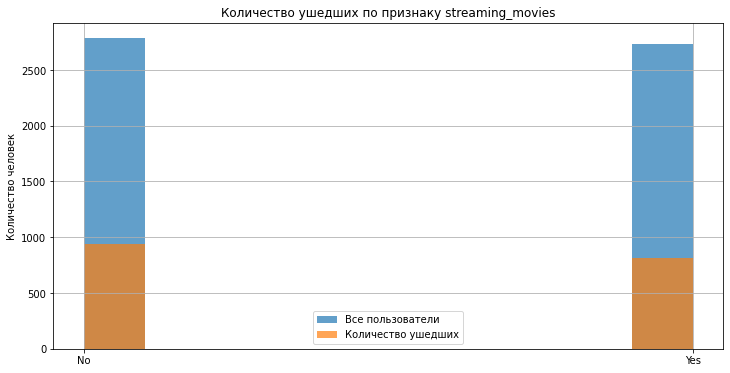

In [95]:
plot_hist(data.loc[(data['streaming_movies'] != -1)], 'streaming_movies')

Но это не относится к признакам streaming_tv, streaming_movies. Люди поддключившие себе данные услуги уходят одинково часто, как и не подключившие их.

### Зависимость от улсуги multiple_lines

In [96]:
data.groupby('multiple_lines')['is_gone'].agg(['mean'])

,mean
multiple_lines,
-1,0.249267
No,0.250442
Yes,0.286099


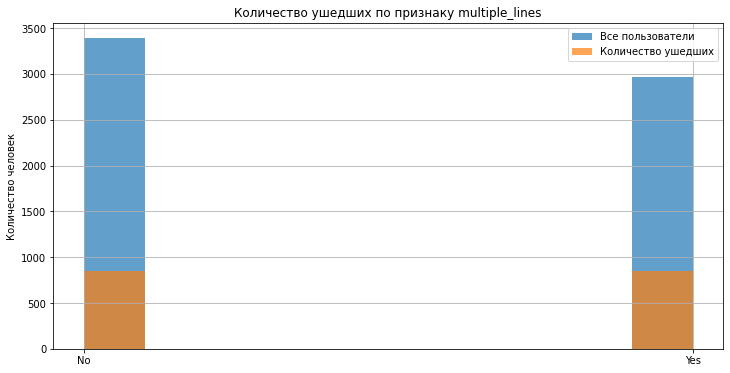

In [97]:
plot_hist(data.loc[(data['multiple_lines'] != -1)], 'multiple_lines')

Уход из компании скорее всего не связан с возмодностью подключения дполонительный линий.

### Вывод

Вследствие исследовательского анализа, можно сделать следующие предположения:

- Люди без бумажных чеков уходят чаще.

- Люди именно с электронным типом чеков уходят чаще.

- Чем дольше действие подписки, тем дольше человек является клиентом.

- Клиенты без партнера уходят чаще.

- При наличие еждевенца клиенты уходят реже 

- Пенсионеры уходят чаще.

- Люди подключившиеся через тип соединения Fiber optic уходят чаще.

- Те, кто подключил услуги: tech_support, online_backup, online_security, device_protection уходят реже.

- Также можно проверить гипотезу: клиенты, кто подключил услуги или кто подключил больше n услуг, уходят реже 

## Linear Regression

Разделим датасет на обучающую и тестовые выборки в соотношении 3 к 1:

In [98]:
features = data.drop(['is_gone'], axis = 1)
target = data['is_gone']

In [99]:
print(f'Размер признаков: {features.shape}')
print(f'Размер целевого признака: {target.shape}')

Размер признаков: (7043, 18)
Размер целевого признака: (7043,)


In [100]:
features_train, features_test, target_train, target_test = train_test_split (
    features, 
    target, 
    test_size=0.25, 
    random_state=311022
)

Техникой One-Hot-Encoding преобразуем категориальные признаки в количественные:

In [101]:
features_train_ohe = pd.get_dummies(features_train, drop_first=True)
features_test_ohe = pd.get_dummies(features_test, drop_first=True)

In [102]:
features_train_ohe.shape

(5282, 29)

In [103]:
features_test_ohe.shape

(1761, 29)

In [104]:
features_train = features_train_ohe
features_test = features_test_ohe

В данных присутствуют количественные признаки с разным разбросом значений. Поэтому следует масштабировать данные. Проведем стандартизацию данных.

In [105]:
scaler = StandardScaler()
scaler.fit(features_train)

features_train = pd.DataFrame (
    
    scaler.transform(features_train), 
    features_train.index, 
    features_train.columns
)

features_test = pd.DataFrame (
    
    scaler.transform(features_test), 
    features_test.index, 
    features_test.columns
    
)

Обучение модели:

In [106]:
LR = LogisticRegression(random_state=311022, solver='liblinear')

In [107]:
scores = cross_val_score (   
    LR, 
    features_train, 
    target_train, 
    cv=10,
    scoring='roc_auc'
)

In [108]:
final_score_f = sum(scores) / len(scores)
print(final_score_f)

0.8468273809010146


Не сильно много, поэтому не буду писать функцию или перебирать другие множества признаков.

Попробуем улучшить показатель применив другие алгоритмы обучения.

## RandomForestRegressor

In [109]:
RFR = RandomForestRegressor()

parametrs = { 'n_estimators': range (20, 141, 40),
              'max_depth': range (1, 10)
            }

grid = GridSearchCV(RFR, parametrs, cv=10, scoring='roc_auc')
grid.fit(features_train, target_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 10),
                         'n_estimators': range(20, 141, 40)},
             scoring='roc_auc')

In [110]:
grid.best_params_

{'max_depth': 8, 'n_estimators': 140}

In [111]:
grid.best_score_

0.8685537031840894

## CatBoostClassifier

In [112]:
CBC = CatBoostClassifier(loss_function="Logloss")

parametrs = { 
    'iterations' : range(10, 201, 10),
    'learning_rate': np.arange (0.1,1.0, 0.1)
}

grid = GridSearchCV(CBC, parametrs, cv=2, scoring='roc_auc')
grid.fit(features_train, target_train)

0:	learn: 0.6327885	total: 49.5ms	remaining: 446ms
1:	learn: 0.5853230	total: 52ms	remaining: 208ms
2:	learn: 0.5467546	total: 54.1ms	remaining: 126ms
3:	learn: 0.5149210	total: 56.2ms	remaining: 84.3ms
4:	learn: 0.4892424	total: 58.4ms	remaining: 58.4ms
5:	learn: 0.4727466	total: 60.6ms	remaining: 40.4ms
6:	learn: 0.4535198	total: 62.7ms	remaining: 26.9ms
7:	learn: 0.4422481	total: 64.9ms	remaining: 16.2ms
8:	learn: 0.4325871	total: 66.9ms	remaining: 7.44ms
9:	learn: 0.4243076	total: 69ms	remaining: 0us
0:	learn: 0.6274531	total: 2.4ms	remaining: 21.6ms
1:	learn: 0.5782309	total: 4.84ms	remaining: 19.4ms
2:	learn: 0.5357529	total: 6.97ms	remaining: 16.3ms
3:	learn: 0.5084654	total: 9.03ms	remaining: 13.6ms
4:	learn: 0.4836087	total: 11.2ms	remaining: 11.2ms
5:	learn: 0.4656626	total: 13.4ms	remaining: 8.96ms
6:	learn: 0.4509434	total: 15.9ms	remaining: 6.79ms
7:	learn: 0.4396890	total: 18.2ms	remaining: 4.55ms
8:	learn: 0.4307774	total: 20.2ms	remaining: 2.25ms
9:	learn: 0.4189668	tot

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f42fbb71370>,
             param_grid={'iterations': range(10, 201, 10),
                         'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
             scoring='roc_auc')

In [113]:
grid.best_params_

{'iterations': 160, 'learning_rate': 0.2}

In [114]:
grid.best_score_

0.8743129794113761

## Подитог

Наилучшая из моделей - CatBoostClassifier с параметрами iterations = 90, learning_rate = 0.3

Далее прверим её на тестовой выборке.

In [115]:
CBC = CatBoostClassifier (
    iterations = 200,
    learning_rate = 0.1,
    verbose = 0,
    loss_function="Logloss",
    random_seed = 311022
)

In [116]:
CBC.fit(features_train, target_train)

In [117]:
eval_pool = Pool(features_test, target_test)
curve = get_roc_curve(CBC, eval_pool)
fpr, tpr, thresholds = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

In [118]:
print(f'Итоговое значение метрики roc_auc: {roc_auc}')

Итоговое значение метрики roc_auc: 0.8941793710852014


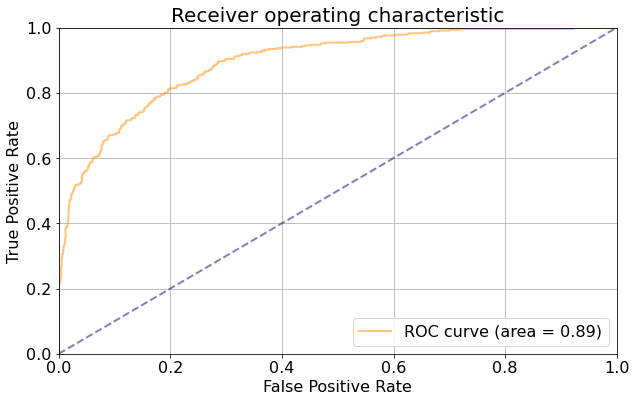

In [119]:
plt.figure(figsize=(10, 6))

plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.00])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

Также рассчитаем матрику accuracy для модели:

In [120]:
pred_valid = CBC.predict(features_test) 

In [121]:
accuracy = accuracy_score(pred_valid, target_test)
print(f'Значение метрики accuracy: {accuracy}')

Значение метрики accuracy: 0.848381601362862


## Вывод

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Поэтому было необходимо предоставить решение - модель, которая может прогнозировать планирует ли клиент уйти или нет. У нас были данные о некоторых клиентах, информация об их тарифах и договорах.

Был проведен осмотр данных, далее предобработка.

Для обучения выбраны **LogisticRegression, RandomForestClassifier, CatBoostClassifier**

Наилучшая модель: **CatBoostClassifier**

Значение метрики **roc_auc** на тестововй выборке: <br>
**roc_auc:** 0.897606128953339, что вполне удовлетворяет заданию.

Также знажение **accuracy:** 0.858603066439523


## План дальнейшей работы: (это для себя оставил)

#### Если будет ещё возможность и время:

0. По окончанию исследовательский анализ совсем на нуле:
- Можно посмотреть как меняются соотношения в признаках у ушедших и не ушедших
- Поставить и проверить гипотезу(ы)


1. Обучение:
- Попробовать OrdEnc для дерева решений и CatBoost. CatBoost без OE и OHE
- У нас дисбаланс классов. Можно попробовать добалансировать.
- Сделать sanity check 
- Всяко есть алгоритмы лучше. Мб какое-то улучшение CatBoost. Попробовать

2. Написать отчет

# Отчёт

У оператора связи «Ниединогоразрыва.ком» был запрос на прогнозирование оттока клиентов. <br>
Компании нужно было решение в виде ML модели, которая сможет предсказывать уйдёт ли клиент из компании. <br>
В нашем распоряжении были данные о некоторых клиентах, информация об их тарифах и договорах.

Заданная метрика моделей - roc_auc. Необходимо было добиться значения от 0.88.

### В первую очередь был проведен осмотр данных, в распоряжении было четыре датасета: 

1. Информация о договоре 


- **customerID** - персональный id пользователя,
- **BeginDate** – дата начала пользования услугами,
- **EndDate** – дата окончания пользования услугами,
- **Type** – тип оплаты: ежемесячный, годовой и тд,
- **PaperlessBilling** – электронный документ об оплате,
- **PaymentMethod** – способ оплаты,
- **MonthlyCharges** – ежемесячные траты на услуги,
- **TotalCharges** – всего потрачено денег на услуги
<br><br>

2. Информация о клиенте


- **customerID** - персональный id пользователя,
- **gender** – пол,
- **SeniorCitizen** – наличие пенсионного статуса по возрасту,
- **Partner** – наличие супруга(и),
- **Dependents** –  наличие иждивенцев
<br><br>



3. Информация об интернет-услугах 

- **customerID** - персональный id пользователя,
- **InternetService** – тип подключения,
- **OnlineSecurity** – наличие блокировки небезопасных сайтов,
- **OnlineBackup** – наличие облачного хранилища файлов для резервного копирования данных,
- **DeviceProtection** –  наличие антивируса,
- **TechSupport** - наличие выделенной линии технической поддержки,
- **StreamingTV** – наличие стримингового телевидения,
- **StreamingMovies** – наличие каталога фильмов
<br><br>



4. Информация об услугах телефонии


- **customerID** - персональный id пользователя,
- **MultipleLines** – наличие возможности ведения параллельных линий во время звонка
<br><br>




На этапе осмотра нам удалось заметить, что количество строк в таблицах не превышает 7043. Явных пропусков нет. 

Новые клиенты приходили в компанию с  2013-10-01 по 2020-02-01 (2020-02-01 - актуальная дата).<br>
Больше всего клиентов пришло в 2019 году - 1957, <br>
Меньше всего в 2016 - 763.

Старые клиенты (ушедшие) оканчивали пользоваться услугами в определенные даты: <br>
2019-11-01, 2019-12-01, 2020-01-01, 2019-10-01,  <br>
Это могло быть связано со спецификой компании, либо с тем, что нам была дана лишь выборка клиентов за это время.

Всего существует три тарифа: оплата от месяца к месяцу, ежегодно, раз в два года. <br>
Около 55% всех пользователей предпочитают оплату от месяца к месяцу,<br>
Ежегодную и двухгодичную предпочитают соответственно 24% и 21% пользователей.<br>

В месяц в среднем платят около 70 (медиана)

Также замечено, что ежемесячный платеж - это волнообразный график, что может говорить о том, что нет четко фиксированного тарифа, но в то же время есть определенные стандартные цены на тарифы. Самый частый ежемесячный платеж - 20.

При просмотре признака оплаты за всё время было замечено, что недавно подключившиеся клиенты (2020-02-01), ещё не успели внести оплату, поэтому их значения в данном признаке были изменены на 0.

А в среднем каждый пользователь заплатил около 1400 (медиана)<br>
При этом разброс значений от 0 до 8684.

Также распределение суммарного платежа -  всё время убывающая зависимость. Что показалось естественным, ведь число людей с большими ежемесячными платежами или число людей пользующихся сервисом долгое время меньше.

В дотасете люди разных полов в соотношении очень близком 1:1<br>
Также в отношении 1:1 у клиентов есть партнер.

Люди в 85% случаев не являются пенсионерами и в 70% случаев не имеют еждевенцов.

Нам также известно, что оператор представляет два вида услуг:

1. Стационарную телефонную связь;
2. Интернет.

При этом по разнице в количествах строк в датасетах мы определили, что не все клиенты пользуются услугами и телефонии и интернета.<br>
Интернет услугами пользуются 5517 человек, услугами телефонии 6361.

### Предобработка данных

Для удобства названия всех колонок были приведены в змеиный регистр.

В датасетах есть общий столбец customer_id. Поэтому было принято решение объеденить таблицы в одну.<br>
Джойн проводился с помощью метода merge. Так как в датасете с договорами есть все 7043 строки, поэтому к нему присоединялись остальные с помощью left join.

При джойне образовались пропуски - они заменены на -1, в будущем имея в ввиду, что это пропуски.

Дубликатов не обнаружено.

Далее были приведены типы колонок дат в формат datetime. Колонок платежей в формат float.

Так как нам необходимо решать задачу бинарной классификации, то принято решение из признаков **end_date** и **begin_date** сделать два других: 

- Клиент ушел или нет **0/1** (is_gone)
- Количество дней пользования услугами **int**

Колонки **end_date** и **begin_date**, а также **customer_id** удалены.

Целевой признак получился несбалансированным, всего 27% ушедших.

### Исследователський анализ данных

На этапе ислледовательского анализа была исследована зависимость ухода от различных признаков.

Была написана общая функция для построения гистограмм, а затем построены и проанализированы графики.

Были сделаны следующие предположения:

- Люди без бумажных чеков уходят чаще.

- Люди именно с электронным типом чеков уходят чаще.

- Чем дольше действие подписки, тем дольше человек является клиентом.

- Клиенты без партнера уходят чаще.

- При наличие еждевенца клиенты уходят реже 

- Пенсионеры уходят чаще.

- Люди подключившиеся через тип соединения Fiber optic уходят чаще.

- Те, кто подключил услуги: tech_support, online_backup, online_security, device_protection уходят реже.

- Также можно проверить гипотезу: клиенты, кто подключил услуги или кто подключил больше n услуг, уходят реже 

### Обучение моделей

Для обучения выбраны следующие модели: 
- Logistic Regression, 
- RandomForestClassifier, 
- CatBoostClassifier.

Перед обучением датасет был разделен на целевой и остальные признаки, а также на тестовую и обучающую выборки.

Далее техникой One-Hot-Encoding преобразованы категориальные признаки в количественные.

Получились датасеты с 29 признаками.

Так как в данных присутствуют количественные признаки с разным разбросом значений, было произведено масштабирование данных (стандартизация).

Далее происходило обучение и валидация Логистической регрессии - LogisticRegression(random_state=311022, solver='liblinear') без дополнительных гиперпараметров с помощью кросс-валидации.

Результат метрики roc_auc: 0.8468273809010146

Далее происходило обучение и валидация Случайного леса с помощью GreedSearchCV, лучшие параметры: max_depth: 8, n_estimators: 140

Результат метрики roc_auc: 0.8685537031840894

Далее обучалась и валидировалась модель CatBoostClassifier с помощью GreedSearchCV, лучшие параметры: iterations: 200, learning_rate: 0.1

Результат метрики roc_auc: 0.8843129794113761

### Итог

Лучшей моделью оказалась CatBoostClassifier

Модель проверена на тестовой выборке, 

Итоговое значение метрики roc_auc: 0.8941793710852014, что удовлетворяет нашим задачам.

Также рассчитвалась метрика accuracy для простоты интерпретации перед заказчиком,

Значение метрики accuracy: 0.848381601362862